# Analysis

To start, we'll import everything we'll likely need:

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import plotly as pty
from prettytable import PrettyTable 

Before we clean our data, it is a good idea to understand the questions we are trying to answer:

1. Are the packet inter-arrival times drawn from some distribution?
2. Do the observed scans follow the scan schedules as specified by the Android API?
3. Are the packet inter-arrival times distinct for each device?
4. Are there any other patterns in the data that may uniquely identify a device (does it favor a particular channel, packets sent, etc)

Each input file conists of N rows of 2 value pairs, where the first value is the time the packet arrived and the second value is the channel on which the packet was seen:
```
12345.6789 11
12345.9876 1
...
```


This format is excellent to reason about whether our data matches the expected scan schedule specified in the Android source code, to do this we'll plot packet number against the time the packet arrived. If our data does match the expected scan schedule, we'll expect big jumps around 20, 40, 60, and 80 seconds since the phones WiFi was enabled and its screen was kept on. A 10 minute sample was taken for both screen on/off scenarios:

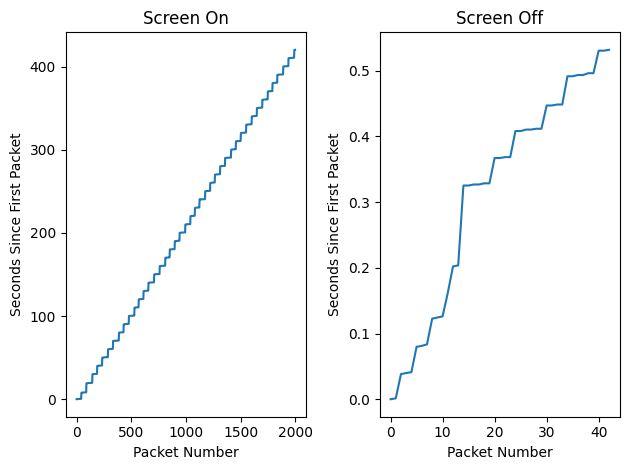

In [57]:
f1 = open("../data/screen_on.txt", "r")
f2 = open("../data/screen_off.txt", "r")

screen_on = []
screen_off = []

for line in f1:
    time, channel = line.strip().split(' ')
    screen_on.append([float(time), channel])


for line in f2:
    time, channel = line.strip().split(' ')
    screen_off.append([float(time), channel])
    

start_time_off = screen_off[0][0]
start_time_on = screen_on[0][0]

screen_on_plot = []
screen_off_plot = []

for i in range(2000):
    
    if i < len(screen_on) - 1:
        screen_on_plot.append(screen_on[i][0] - start_time_on)
        
    if i < len(screen_off) - 1:
        screen_off_plot.append(screen_off[i][0] - start_time_off)



# plot the screen on dataset
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(range(2000), screen_on_plot)
ax2.plot(range(len(screen_off_plot)), screen_off_plot)
ax1.set_title('Screen On')
ax2.set_title('Screen Off')
ax1.set_xlabel('Packet Number')
ax2.set_xlabel('Packet Number')
ax1.set_ylabel('Seconds Since First Packet')
ax2.set_ylabel('Seconds Since First Packet')
fig.tight_layout()
plt.show()

Two things we should note right away:

1. When the screen if off, scans are not made. This coincides with the Android source code which has this check:
```java
private void periodicScanTimerHandler() {
    localLog("periodicScanTimerHandler");

    // Schedule the next timer and start a single scan if screen is on.
    if (mScreenOn) {
        startPeriodicSingleScan();
    }
}
```

2. When the screen is on, the scans follow some sort of periodic behavior. 


Because of (1), we'll only look at the data with the screen on.


Let's take a closer look at the first 1000 packets to get a better idea of the periodic behavior.

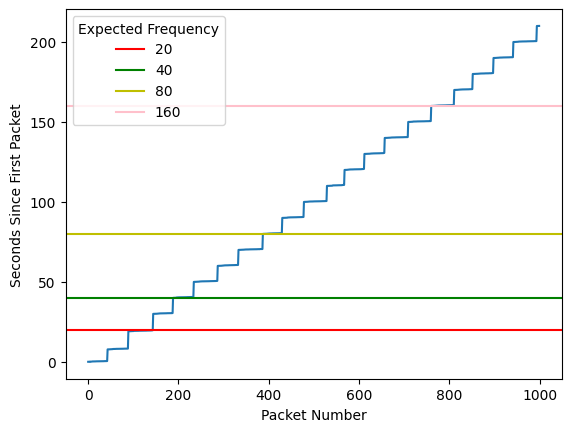

In [54]:
# plot the screen on dataset
plt.plot(range(1000), screen_on_plot[:1000])
plt.axhline(y=20, color='r', linestyle='-', label="20")
plt.axhline(y=40, color='g', linestyle='-', label="40")
plt.axhline(y=80, color='y', linestyle='-', label="80")
plt.axhline(y=160, color='pink', linestyle='-', label="160")
plt.xlabel('Packet Number')
plt.ylabel('Seconds Since First Packet')
plt.legend(title="Expected Frequency")
plt.show()

We can see that the output pattern doesn't match the expected scan frequency as specified by the Android source code. Instead it appears that they occur every 10 seconds:

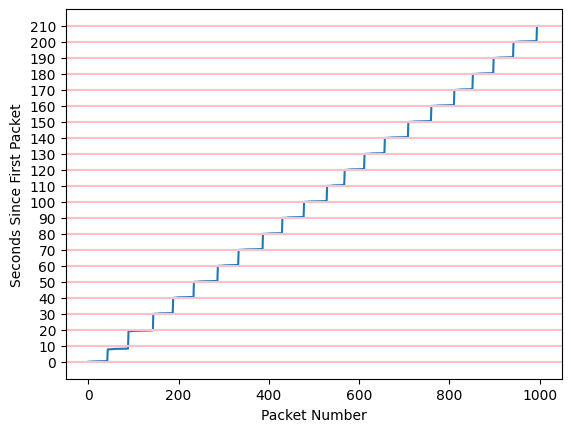

In [56]:
# plot the screen on dataset
plt.plot(range(1000), screen_on_plot[:1000])
labels = [i for i in range(211) if i % 10 == 0]
for line in labels:
    plt.axhline(y=line, color='pink', linestyle='-', label="160")
    

    
plt.yticks(labels)
plt.xlabel('Packet Number')
plt.ylabel('Seconds Since First Packet')
plt.show()

This may have been due to leaving networking screen on (rather than just say, the homescreen. Later on, we'll run more situations and can confirm whether or not different situations behave the same.

From this point on, we won't be using the absolute timestamps. Instead we'll be using inter-arrival time between each packet. Let's convert the old format into something more usable:

```
0.01 1 6
0.007 6 6
...
```

Each row conists of (1) the time between the two packets, (2) the channel the first packet was sent on, and (3) the channel the second packet was sent on. Let's generate this data:

In [60]:
def generate_dataset(raw):
    out = []
    for index, (time, channel) in enumerate(raw):
        if index == 0:
            continue
        
        prev_time, prev_channel = raw[index - 1]
        out.append([float(time) - float(prev_time), prev_channel, channel])
        
    return np.array(out)


screen_on_r = generate_dataset(screen_on_a)

The next step is figuring out how to remove outliers. Recall that the times between packets in the same scan is small (<<1 second) while the time between two packets in different scans is very large. Therefore, any cutoff around 1 should be acceptable. For now, we'll use 2 as the cutoff although we can revisit it later if something doesn't seem right.

In [124]:
cutoff = 2

Therefore, our cutoff of 2 is fine, because the inter-arrival times are either far greater, or far less than 2. Let's split up the data based on this thresold and get some summary statistics from them:

In [125]:
bins_close = {}
bins_far = {}
for first in ["1", "6", "11"]:
    for second in ["1", "6", "11"]:
        bins_far["{}->{}".format(first, second)] = []
        bins_close["{}->{}".format(first, second)] = []


for time, start, finish in screen_on_r:
    time = float(time)
    if time > 0 and time < cutoff:
        bins_close["{}->{}".format(start, finish)].append(time)
        
    elif time > 0 and time >= cutoff:
        bins_far["{}->{}".format(start, finish)].append(time)

        
    

x = PrettyTable()
x.field_names = ["Channel", "Median", "Mean", "Standard Deviation", "Min", "Max", "Occurences"]

rows = []
for k, v in bins_close.items():
    if len(v) > 0:
        rows.append([k, np.median(v), np.mean(v), np.std(v), np.min(v), np.max(v), len(v)])
    
x.add_rows(rows)
x.align = "r"
print("Under 2 Seconds")
print(x)
print("\n\n")


y = PrettyTable()
y.field_names = ["Channel", "Median", "Mean", "Standard Deviation", "Min", "Max", "Occurences"]
rows = []
for k, v in bins_far.items():
    if len(v) > 0:
        rows.append([k, np.median(v), np.mean(v), np.std(v), np.min(v), np.max(v), len(v)])
    
y.add_rows(rows)
y.align = "r"
print("2 or more Seconds")
print(y)

Under 2 Seconds
+---------+-----------------------+----------------------+----------------------+-----------------------+---------------------+------------+
| Channel |                Median |                 Mean |   Standard Deviation |                   Min |                 Max | Occurences |
+---------+-----------------------+----------------------+----------------------+-----------------------+---------------------+------------+
|    1->1 | 0.0024330615997314453 | 0.016766490874352395 | 0.026811723973702014 | 0.0012559890747070312 | 0.44407105445861816 |        616 |
|    1->6 |   0.08040750026702881 |   0.0819623853479113 |   0.0431878288191371 |  0.033653974533081055 | 0.20553994178771973 |         56 |
|    6->6 |  0.002583026885986328 | 0.017749960055918054 |   0.0204484849594133 | 0.0012578964233398438 | 0.12343907356262207 |        917 |
+---------+-----------------------+----------------------+----------------------+-----------------------+---------------------+-----------

From the table, we can note the following:
1. Channel 11 wasn't used at all
2. Every time a new scan started, it started on channel 1.
3. The mean time between scans is approximately 10 seconds
4. There is a large amount of variance in the inter-arrival times


To be more confident in our observations, we'll need far more samples. By taking 10 different 30 minute samples, we should get enough events to get a reliable data set. Samples will be taken every hour starting at 9am and ending at 6pm. Each sample will have the phone either at the homescreen (1,2,3,4,5), or in a network dependent site (6,7,8,9,10) such as a website with live updates.